In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
base_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"
df = pd.read_csv(base_path + 'mrp_final_dataset.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['majority_label'])  # Maps labels to integers

In [ ]:
df['label'].value_counts()

,count
label,
1,3584
0,2879


# Train RoBERTa-Offensive Model with best configuration of hyperparameters

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463 entries, 0 to 6462
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            6463 non-null   object
 1   majority_label  6463 non-null   object
 2   label           6463 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 151.6+ KB


In [ ]:
df['label'].value_counts()

,count
label,
1,3584
0,2879


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import TweetTokenizer
import torch
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Train RoBERTa-offensive model with best configuration of hyperparameters

In [ ]:
 # 80% for training/validation, 20% final test
train_eval_df, final_test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Split the 80%: 10% of it (8% total) for eval
train_df, eval_df = train_test_split(
    train_eval_df,
    test_size=0.1,
    random_state=42,
    stratify=train_eval_df['label']
)

print("Train size:", len(train_df))
print("Eval size:", len(eval_df))
print("Final test size:", len(final_test_df))

train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
final_test_dataset = Dataset.from_pandas(final_test_df)
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-dec2021-offensive')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)
model = RobertaForSequenceClassification.from_pretrained(
    'cardiffnlp/twitter-roberta-base-dec2021-offensive',
    num_labels=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Train size: 4653
Eval size: 517
Final test size: 1293


tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.05,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics
)
trainer.train()
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.405800,0.391227,0.823985,0.824092,0.824256,0.823985
2,0.232000,0.509565,0.823985,0.821431,0.828757,0.823985
3,0.113800,0.782370,0.818182,0.816355,0.820247,0.818182
4,0.053300,0.966386,0.816248,0.816031,0.815969,0.816248
5,0.021700,1.092983,0.812379,0.811606,0.812226,0.812379


Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.339747
eval_accuracy              0.863109
eval_f1                    0.863121
eval_precision             0.863133
eval_recall                0.863109
eval_runtime               7.875900
eval_samples_per_second  164.171000
eval_steps_per_second      5.206000
epoch                      5.000000


               precision    recall  f1-score   support

Non-offensive       0.85      0.85      0.85       576
    Offensive       0.88      0.88      0.88       717

     accuracy                           0.86      1293
    macro avg       0.86      0.86      0.86      1293
 weighted avg       0.86      0.86      0.86      1293



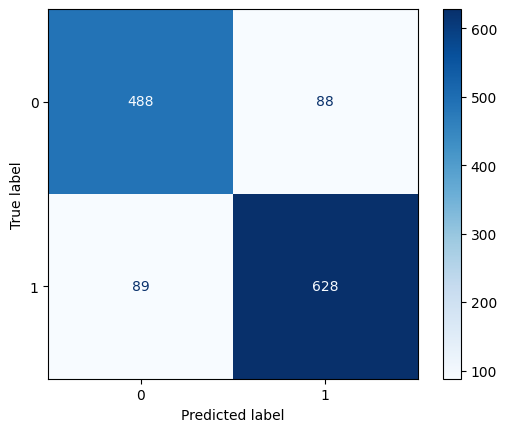

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

##  Save RoBERTa Final Test Set Probabilities

In [ ]:
# Get probabilities for class 1 (offensive)
probs_roberta = tf.nn.softmax(predictions_output.predictions, axis=1)[:, 1]  # shape: (num_samples,)

# Train CNN-BiLSTM model with best configuration of hyperparameters

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import random
import os

In [ ]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [ ]:
train_eval_df, final_test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_eval_df, test_size=0.1, random_state=42, stratify=train_eval_df['label'])

tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

def prepare_data(texts, tokenizer, max_len=100):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len)

X_train = prepare_data(train_df['text'], tokenizer)
X_val = prepare_data(val_df['text'], tokenizer)
X_test = prepare_data(final_test_df['text'], tokenizer)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = final_test_df['label'].values

In [ ]:
def build_cnn_bilstm_model(vocab_size=20000, input_length=128):
    """
    CNN-BiLSTM model with best F1-score configuration:
    - Embedding dimension: 200
    - Conv1D filters: 64, kernel size: 5
    - BiLSTM units: 256
    - Dropout rate: 0.3
    - Binary classification
    """
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=200, input_length=input_length),     # embed_dim=200
        Conv1D(filters=64, kernel_size=5, activation='relu'),                          # filters=64
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(units=256)),                                                # lstm_units=256
        Dropout(rate=0.3),                                                             # dropout_rate=0.3
        Dense(1, activation='sigmoid')                                                 # binary classification
    ])
    return model

In [ ]:
# Load CNN-BiLSTM
cnn_bilstm_model = build_cnn_bilstm_model()
cnn_bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Get CNN-BiLSTM Probabilities

In [ ]:
# During training
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])  # Keras tokenizer

In [ ]:
def prepare_input_cnn(texts, tokenizer, max_len=128):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Preprocess test data like during training
x_test_seq = prepare_input_cnn(final_test_df['text'], tokenizer)
probs_cnn = cnn_bilstm_model.predict(x_test_seq).flatten()

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


## Average Ensemble

In [ ]:
# Soft voting: convert RoBERTa tensor to NumPy first
probs_ensemble = (probs_roberta.numpy() + probs_cnn) / 2.0

# Binary prediction
y_ensemble_pred = (probs_ensemble >= 0.5).astype(int)

## Evaluate Ensemble Performance


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("Ensemble Accuracy:", accuracy_score(y_true, y_ensemble_pred))
print(classification_report(y_true, y_ensemble_pred, target_names=le.classes_))


Ensemble Accuracy: 0.8623356535189481
               precision    recall  f1-score   support

Non-offensive       0.85      0.85      0.85       576
    Offensive       0.88      0.88      0.88       717

     accuracy                           0.86      1293
    macro avg       0.86      0.86      0.86      1293
 weighted avg       0.86      0.86      0.86      1293



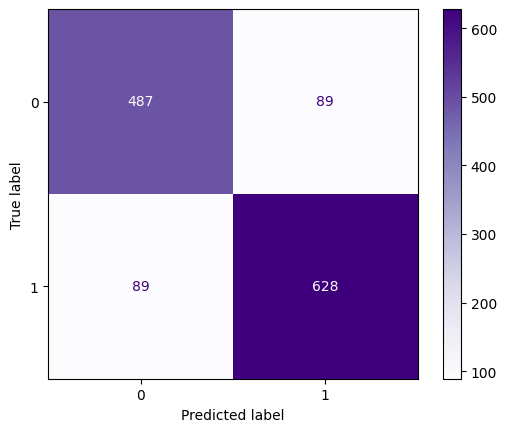

In [ ]:
cm = confusion_matrix(y_true, y_ensemble_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Purples')
